# Compare Time Series Foundation Models

## Import libraries

In [1]:
import pandas as pd

from timecopilot import TimeCopilotForecaster


## Load the dataset 

The DataFrame must include at least the following columns:
- unique_id: Unique identifier for each time series (string)
- ds: Date column (datetime format)
- y: Target variable for forecasting (float format)

The pandas frequency will be inferred from the ds column, if not provided.
If the seasonality is not provided, it will be inferred based on the frequency. 
If the horizon is not set, it will default to 2 times the inferred seasonality.

In [2]:
df = pd.read_csv(
    "https://timecopilot.s3.amazonaws.com/public/data/events_pageviews.csv",
    parse_dates=["ds"],
)
df.head()


,unique_id,ds,y
0,Oktoberfest,2020-01-31,25376
1,Oktoberfest,2020-02-29,28470
2,Oktoberfest,2020-03-31,23816
3,Oktoberfest,2020-04-30,46186
4,Oktoberfest,2020-05-31,31213


## Plot the data

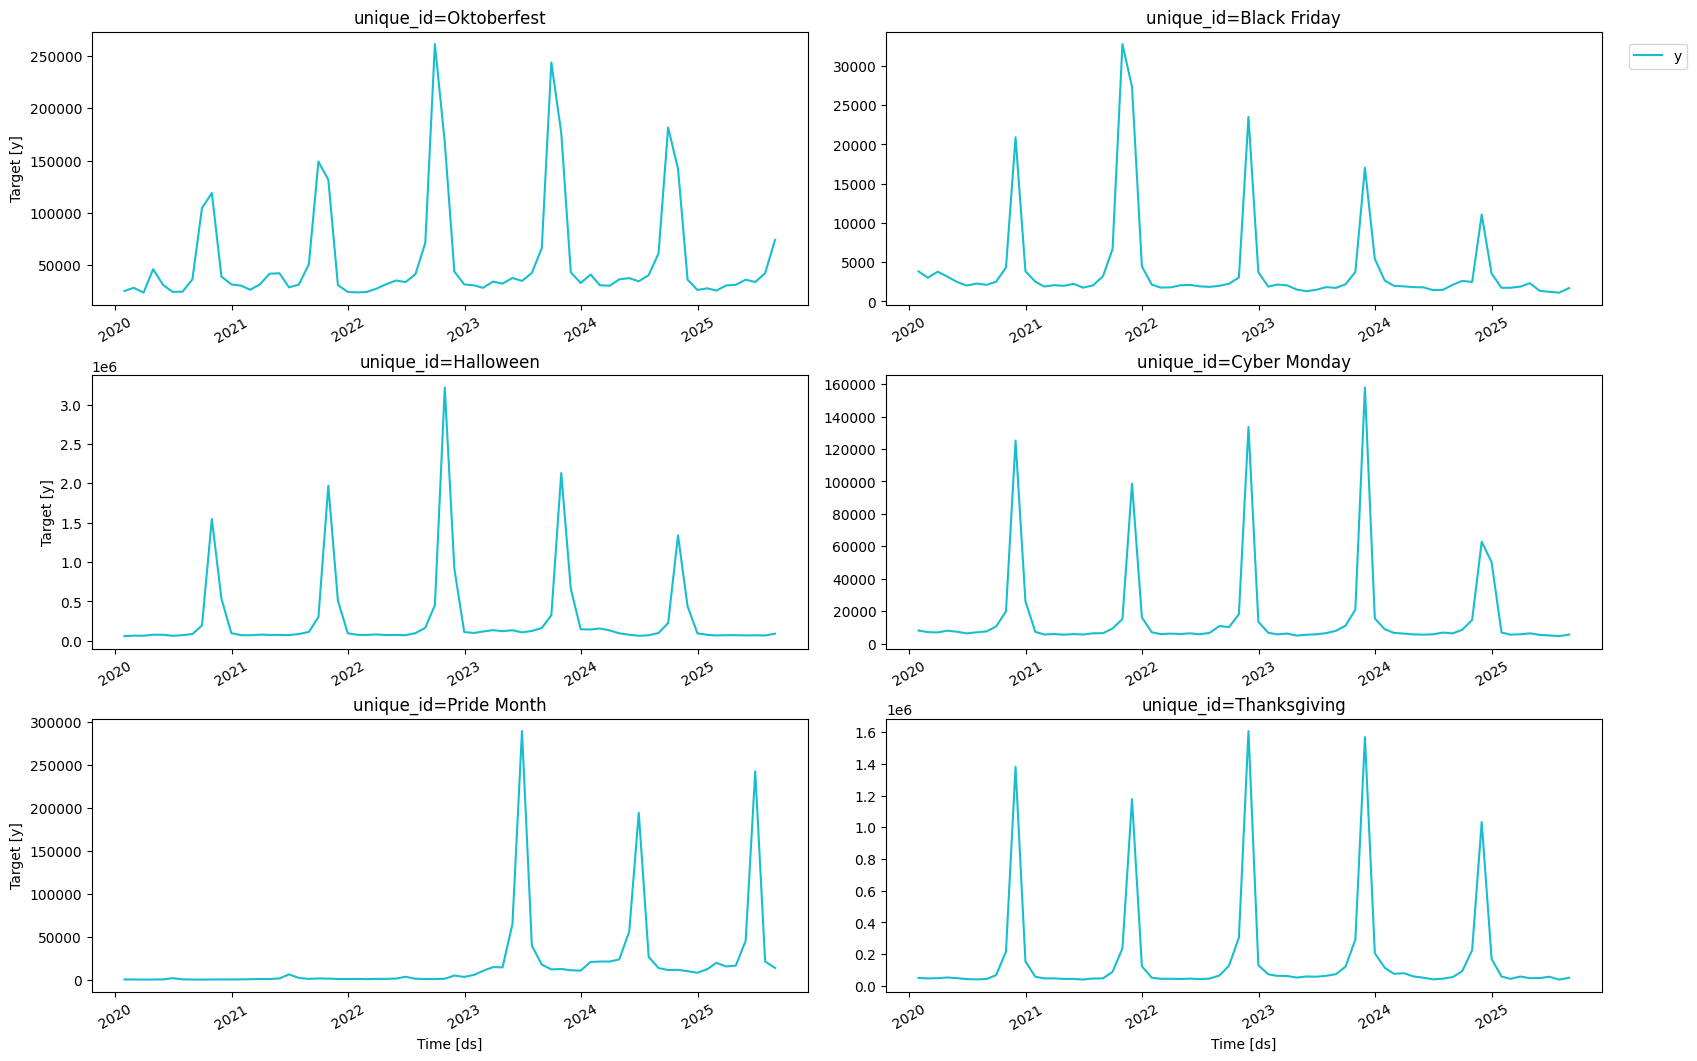

In [3]:
TimeCopilotForecaster.plot(df)

## Import the models you want to use

In [11]:
from timecopilot.models.foundation.chronos import Chronos
from timecopilot.models.foundation.moirai import Moirai
from timecopilot.models.foundation.timesfm import TimesFM
from timecopilot.models.stats import AutoARIMA, SeasonalNaive


## Create a TimeCopilotForecaster


In [16]:

tcf = TimeCopilotForecaster(
    models=[
        AutoARIMA(),
        Chronos(repo_id="amazon/chronos-bolt-small"),
        Moirai(), 
        TimesFM(repo_id="google/timesfm-2.5-200m-pytorch", alias="TimesFM-2.5"), 
        TimesFM(repo_id="google/timesfm-2.0-500m-pytorch", alias="TimesFM-2.0"), 
        SeasonalNaive(),
    ]
)


## Generate forecast 

You can optionally specify the following parameters:
- freq: The frequency of your data (e.g., 'D' for daily, 'M' for monthly)
- h: The forecast horizon, which is the number of periods to predict
- seasonality: The seasonal period of your data, which can be inferred if not provided


In [ ]:
level = [0, 20, 40, 60, 80] # zero level is strange (it's the median/point forecast), but that comes from the required inputs by TimesFM
cv_df = tcf.cross_validation(df=df, h=12, level=level) 

## Plot results

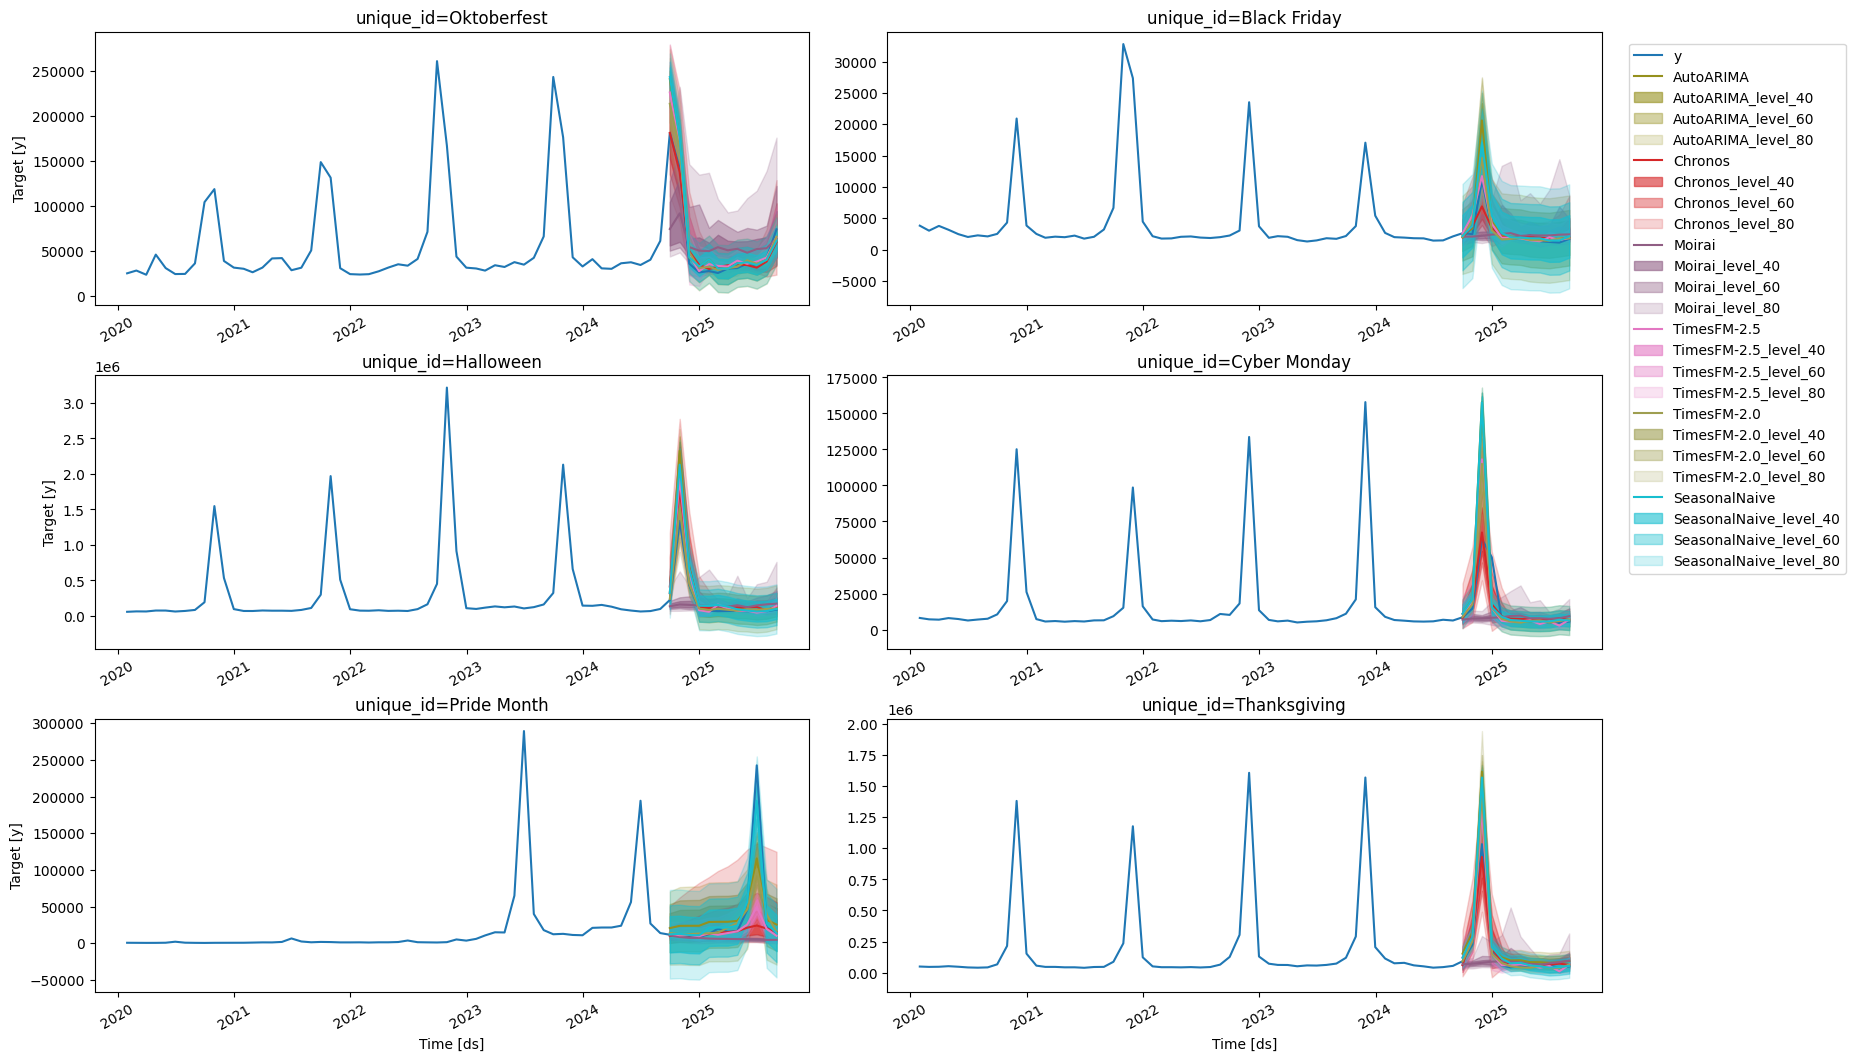

In [32]:
tcf.plot(df, cv_df.drop(columns=["cutoff", "y"]), level=[40, 60, 80])

In [33]:
cv_df.head()

,unique_id,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-80,AutoARIMA-lo-60,AutoARIMA-lo-40,AutoARIMA-lo-20,AutoARIMA-lo-0,...,SeasonalNaive-lo-0,SeasonalNaive-lo-20,SeasonalNaive-lo-40,SeasonalNaive-lo-60,SeasonalNaive-lo-80,SeasonalNaive-hi-0,SeasonalNaive-hi-20,SeasonalNaive-hi-40,SeasonalNaive-hi-60,SeasonalNaive-hi-80
0,Black Friday,2024-09-30,2024-08-31,2607,2345.021484,-3894.636719,-1752.690186,-208.196136,1111.517090,2345.021484,...,2160.0,518.105774,-1238.539673,-3294.386475,-6145.491211,2160.0,3801.894287,5558.539551,7614.386719,10465.491211
1,Black Friday,2024-10-31,2024-08-31,2470,3356.209473,-3393.586182,-1076.520020,594.247681,2021.857178,3356.209473,...,3746.0,2104.105713,347.460358,-1708.386597,-4559.491211,3746.0,5387.894043,7144.539551,9200.386719,12051.491211
2,Black Friday,2024-11-30,2024-08-31,11058,20597.349609,13847.554688,16164.620117,17835.388672,19262.998047,20597.349609,...,17053.0,15411.105469,13654.459961,11598.613281,8747.508789,17053.0,18694.894531,20451.539062,22507.386719,25358.490234
3,Black Friday,2024-12-31,2024-08-31,3548,4478.090332,-2271.705078,45.361053,1716.128784,3143.738281,4478.090332,...,5407.0,3765.105713,2008.460327,-47.386593,-2898.491211,5407.0,7048.894043,8805.540039,10861.386719,13712.491211
4,Black Friday,2025-01-31,2024-08-31,1724,2228.328369,-4521.467285,-2204.401123,-533.633362,893.976074,2228.328369,...,2656.0,1014.105774,-742.539673,-2798.386475,-5649.491211,2656.0,4297.894043,6054.539551,8110.386719,10961.491211


## Evaluation

In [71]:
from functools import partial

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mase, scaled_crps

In [73]:
eval_df = evaluate(
    cv_df.drop(columns=["cutoff"]), 
    train_df=df.query("ds <= '2024-08-31'"), 
    metrics=[partial(mase, seasonality=12), scaled_crps],
    level=level,
)
eval_df.groupby("metric").mean(numeric_only=True).T.sort_values(by="scaled_crps").round(3)

metric,mase,scaled_crps
TimesFM-2.0,1.086,0.260
Chronos,0.985,0.311
TimesFM-2.5,1.233,0.335
SeasonalNaive,1.576,0.503
AutoARIMA,1.897,0.560
Moirai,2.430,0.616
